# CS230 - Project Code
Student: Yonglai Zhu

## Part 1. Set up the Trading Environment

In [2]:
import numpy as np
import pandas as pd
import gym
from gym import spaces

class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.balance = 10000  # starting balance in USD
        self.stock_held = 0
        self.total_shares_bought = 0
        self.total_cost = 0
        self.total_profit = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(df.shape[1] - 1,), dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.stock_held = 0
        self.total_shares_bought = 0
        self.total_cost = 0
        self.total_profit = 0
        return self._get_observation()

    def _get_observation(self):
        return self.df.iloc[self.current_step, 1:].values

    def _take_action(self, action):
        current_price = self.df.iloc[self.current_step]["Close"]

        if action == 1:  # Buy
            shares_to_buy = self.balance // current_price
            self.balance -= shares_to_buy * current_price
            self.stock_held += shares_to_buy
            self.total_shares_bought += shares_to_buy
            self.total_cost += shares_to_buy * current_price

        elif action == 2 and self.stock_held > 0:  # Sell
            self.balance += self.stock_held * current_price
            self.stock_held = 0

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        if self.current_step >= len(self.df) - 1:
            done = True
        else:
            done = False

        reward = self.balance + (self.stock_held * self.df.iloc[self.current_step]["Close"]) - 10000
        return self._get_observation(), reward, done, {}

    def render(self):
        pass  # For simplicity, render can be customized later


## Part 2. Data Preparation


In [3]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Spotify
ticker = 'SPOT'

# Fetch historical stock price data
stock_data = yf.download(ticker, start='2020-11-10', end='2024-11-10')

data = pd.DataFrame(stock_data)

data.reset_index(inplace=True)

# Load dataset
data["Date"] = pd.to_datetime(data["Date"])

# Feature Engineering (e.g., moving averages)
data["MA50"] = data["Close"].rolling(window=50).mean()
data["MA200"] = data["Close"].rolling(window=200).mean()
data.set_index("Date", inplace=True)
data = data.dropna()

print(data.head())
print("Dataset length after dropna:", len(data))

[*********************100%***********************]  1 of 1 completed

Price                       Adj Close       Close        High         Low  \
Ticker                           SPOT        SPOT        SPOT        SPOT   
Date                                                                        
2021-08-26 00:00:00+00:00  224.619995  224.619995  227.520004  222.481995   
2021-08-27 00:00:00+00:00  226.020004  226.020004  227.820007  225.490005   
2021-08-30 00:00:00+00:00  233.119995  233.119995  234.397995  225.945007   
2021-08-31 00:00:00+00:00  234.339996  234.339996  235.419998  232.250000   
2021-09-01 00:00:00+00:00  238.380005  238.380005  239.169998  235.009995   

Price                            Open   Volume        MA50       MA200  
Ticker                           SPOT     SPOT                          
Date                                                                    
2021-08-26 00:00:00+00:00  224.070007  1125800  239.104399  275.771049  
2021-08-27 00:00:00+00:00  225.490005  1338800  238.682599  275.651199  
2021-08-30 00:00:0

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Open", "High", "Low", "Close", "Volume", "Adj Close", "MA50", "MA200"]])
data_normalized = pd.DataFrame(scaled_data, columns=["Open", "High", "Low", "Close", "Volume", "Adj Close", "MA50", "MA200"], index=data.index)

# Split into training and testing datasets
train_data = data_normalized.loc[:'2023-11-10']
test_data = data_normalized.loc['2023-11-11':]

# Initialize Environment
train_env = TradingEnv(train_data)
test_env = TradingEnv(test_data)

print("Training dataset length:", len(train_data))
print("Testing dataset length:", len(test_data))
print(train_data.head())

Training dataset length: 557
Testing dataset length: 250
                               Open      High       Low     Close    Volume  \
Date                                                                          
2021-08-26 00:00:00+00:00  0.464947  0.465198  0.467000  0.465886  0.044413   
2021-08-27 00:00:00+00:00  0.469287  0.466097  0.476169  0.470133  0.059508   
2021-08-30 00:00:00+00:00  0.471701  0.485815  0.477556  0.491672  0.039700   
2021-08-31 00:00:00+00:00  0.493796  0.488879  0.496776  0.495374  0.050855   
2021-09-01 00:00:00+00:00  0.502934  0.500120  0.505190  0.507630  0.022104   

                           Adj Close      MA50     MA200  
Date                                                      
2021-08-26 00:00:00+00:00   0.465886  0.558088  0.835558  
2021-08-27 00:00:00+00:00   0.470133  0.556625  0.834997  
2021-08-30 00:00:00+00:00   0.491672  0.555619  0.834344  
2021-08-31 00:00:00+00:00   0.495374  0.554838  0.833774  
2021-09-01 00:00:00+00:00   0.50763

## Part 3. Set up the DQN Agent

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque
import random

# Define the DQN model
def create_model(input_shape, num_actions):
    model = tf.keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=input_shape),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_actions, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Initialize the model
num_actions = train_env.action_space.n
num_states = train_env.observation_space.shape
model = create_model((num_states[0],), num_actions)

# Replay buffer
replay_memory = deque(maxlen=2000)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Part 4. DQN Training Loop

In [7]:
# Hyperparameters for faster training
episodes = 5  # Reduced from 100
max_steps = 10  # Limit each episode to 500 steps
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
discount_factor = 0.95
batch_size = 16  # Reduced from 32
# replay_memory = deque(maxlen=1000)  # Reduced from 2000

# Training loop
for episode in range(episodes):
    state = train_env.reset()
    state = np.reshape(state, [1, num_states[0]])
    total_reward = 0

    for t in range(max_steps):  # Cap steps per episode
        # Exploration vs. exploitation
        if np.random.rand() <= epsilon:
            action = random.randrange(num_actions)
        else:
            action = np.argmax(model.predict(state)[0])

        # Take action and observe the result
        next_state, reward, done, _ = train_env.step(action)
        next_state = np.reshape(next_state, [1, num_states[0]])

        # Store experience in replay buffer
        replay_memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Sample from replay buffer and train the model
        if len(replay_memory) > batch_size:
            minibatch = random.sample(replay_memory, batch_size)
            for s, a, r, ns, d in minibatch:
                target = r
                if not d:
                    target += discount_factor * np.amax(model.predict(ns)[0])
                target_f = model.predict(s)
                target_f[0][a] = target
                model.fit(s, target_f, epochs=1, verbose=0)

        if done:
            break

    # Reduce exploration rate
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")


Episode 1/5, Total Reward: 11156.695955228784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1

## Part 5. Model Evaluation

In [10]:
import matplotlib.pyplot as plt

state = test_env.reset()
state = np.reshape(state, [1, num_states[0]])
total_profit = 0
total_rewards = 0
rewards_over_time = []  # Store cumulative rewards at each step
step_rewards = []  # Store rewards for each step

for t in range(len(test_data) - 1):
    action = np.argmax(model.predict(state)[0])  # Always exploit during evaluation
    next_state, reward, done, _ = test_env.step(action)
    state = np.reshape(next_state, [1, num_states[0]])
    total_rewards += reward
    rewards_over_time.append(total_rewards)  # Append cumulative rewards
    step_rewards.append(reward)  # Log step reward


    if done:
        break

print(f"Total reward on test data: {total_rewards}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

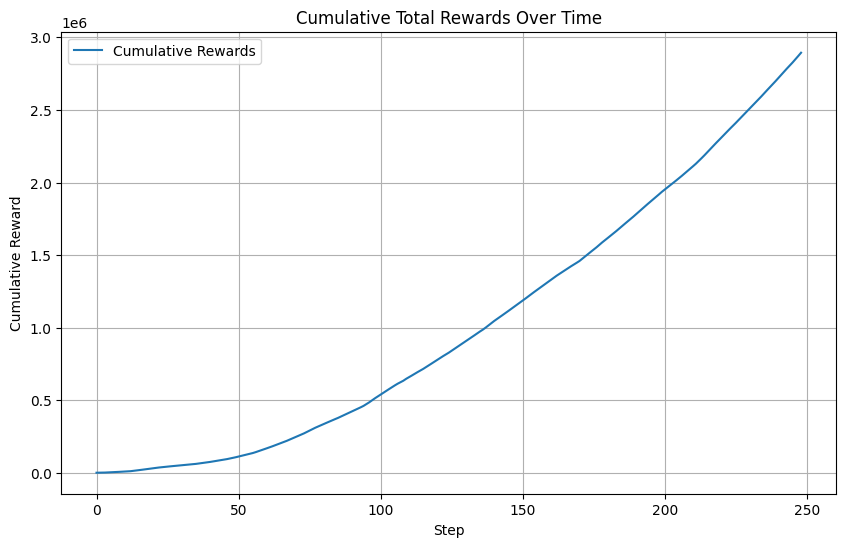

In [19]:
# Plot cumulative rewards
plt.figure(figsize=(10, 6))
plt.plot(rewards_over_time, label="Cumulative Rewards")
plt.title("Cumulative Total Rewards Over Time")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid()
plt.show()

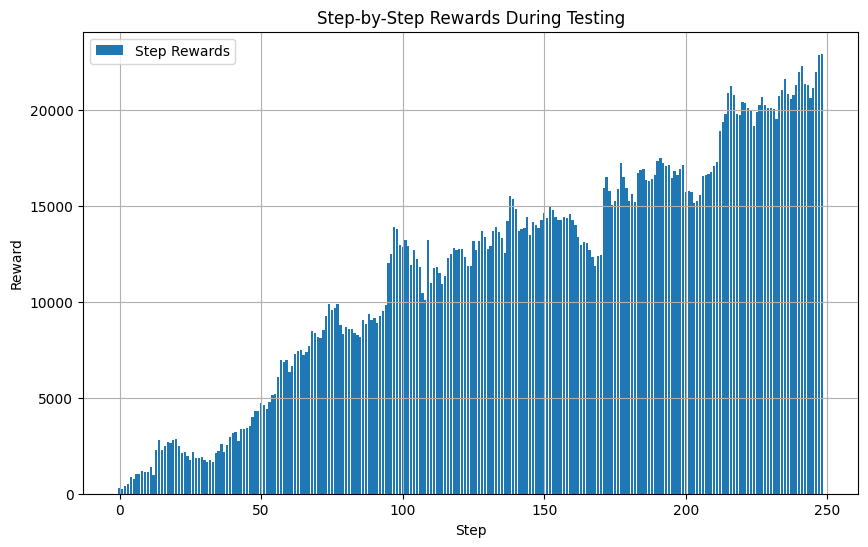

In [20]:
# Plot rewards at each step
plt.figure(figsize=(10, 6))
plt.bar(range(len(step_rewards)), step_rewards, label="Step Rewards")
plt.title("Step-by-Step Rewards During Testing")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

culumative regret
- the best we could collect vs. the actual we collect
- converge to optimal policy - regret converge
- explain something's wrong or not

# Baseline Model

- use for comparison
- justify why this is a baseline (popular? other papers have used?)

In [22]:
cash = 10000
stock_held = 0
portfolio_values = []

for t in range(1, len(test_data)):
    short_ma = test_data.iloc[t]["MA50"]
    long_ma = test_data.iloc[t]["MA200"]
    current_price = test_data.iloc[t]["Close"]

    # Buy signal
    if short_ma > long_ma and stock_held == 0:
        stock_held = cash // current_price
        cash -= stock_held * current_price

    # Sell signal
    elif short_ma < long_ma and stock_held > 0:
        cash += stock_held * current_price
        stock_held = 0

    # Track portfolio value
    portfolio_values.append(cash + (stock_held * current_price))

final_portfolio_value = cash + (stock_held * test_data.iloc[-1]["Close"])
print(f"Moving Average Crossover Final Portfolio Value: ${final_portfolio_value}")


Moving Average Crossover Final Portfolio Value: $31891.1399046718


# Regret Analysis

In [5]:
import numpy as np

# Calculate Theoretical Maximum Profit
prices = test_data["Close"].values
cash = 10000  # Initial cash
shares = 0
max_profit = 0

for i in range(1, len(prices) - 1):
    # Buy at a local minimum
    if prices[i] < prices[i - 1] and prices[i] < prices[i + 1]:
        shares += cash // prices[i]
        cash -= shares * prices[i]

    # Sell at a local maximum
    elif prices[i] > prices[i - 1] and prices[i] > prices[i + 1]:
        cash += shares * prices[i]
        shares = 0

# Final value (sell remaining shares at the last price)
cash += shares * prices[-1]
max_profit = cash - 10000  # Subtract initial investment

print(f"Theoretical Maximum Profit: {max_profit}")


Theoretical Maximum Profit: 210955.00810243908
